In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.sparse import csr_matrix

In [3]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [6]:
df_songs = pd.read_csv('../data/new_songs.csv')

In [7]:
df_songs.head()

,user_id,song_id,listen_count,Title,AlbumName,ArtistName,Year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1,b'Tu Quieres Volver',b'Greatest Hits',b'Gipsy Kings',1987
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SODCXXY12AB0187452,2,b'Freaxxx',b'BC 13-EP',b'brokeNCYDE',2008
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOWPAXV12A67ADA046,18,b'Push It',b'Ultimate Girl Groups',b'Salt-N-Pepa',1988
3,b64cdd1a0bd907e5e00b39e345194768e330d652,SOLXDDC12A6701FBFD,1,"""bI'm Back""""""""""",b'The Marshall Mathers LP',b'Eminem',2000
4,b64cdd1a0bd907e5e00b39e345194768e330d652,SONJBQX12A6D4F8382,4,b'Da Funk',b'Homework',b'Daft Punk',1995


In [8]:
song_user = df_songs.groupby('song_id')['user_id'].count()

/var/folders/5b/_80n_r3s42d_yc94yjfdh__c0000gn/T/ipykernel_36391/2680384587.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(song_user.values, color='red')


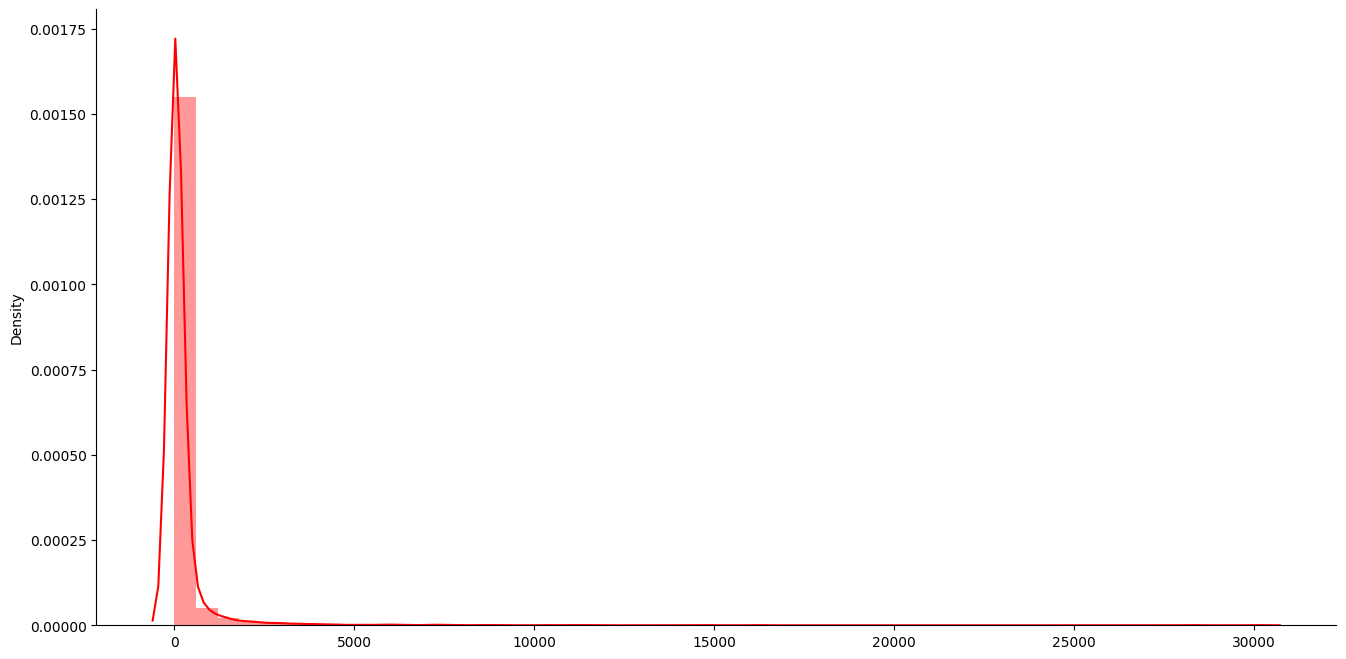

In [9]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='red')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();


In [10]:
print(f"A song is listened for an average of {np.mean(song_user)} users, with minimum {np.min(song_user)} and maximum {np.max(song_user)} users")

A song is listened for an average of 210.24789115646257 users, with minimum 1 and maximum 30117 users


In [11]:
# Get how many songs each user have listened to
user_counts = df_songs.groupby('user_id')['song_id'].count()

# Filter users which have listen to at least 16 songs
user_ten_id = user_counts[user_counts > 16].index.to_list()

In [12]:
# Get how many user have listened to each song
song_counts = df_songs.groupby('song_id')['user_id'].count()

# Get songs which have been listened at least 4 times
song_ten_id = song_counts[song_counts > 200].index.to_list()


In [13]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_reduced = df_songs[(df_songs['user_id'].isin(user_ten_id)) & (df_songs['song_id'].isin(song_ten_id))].reset_index(drop=True)

In [14]:
df_song_reduced.shape

(3552, 7)

In [15]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]

In [16]:
df_song_reduced['listen_count'] = pd.cut(df_song_reduced['listen_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [17]:
listen_counts = pd.DataFrame(df_song_reduced.groupby('listen_count').size(), columns=['count']).reset_index(drop=False)

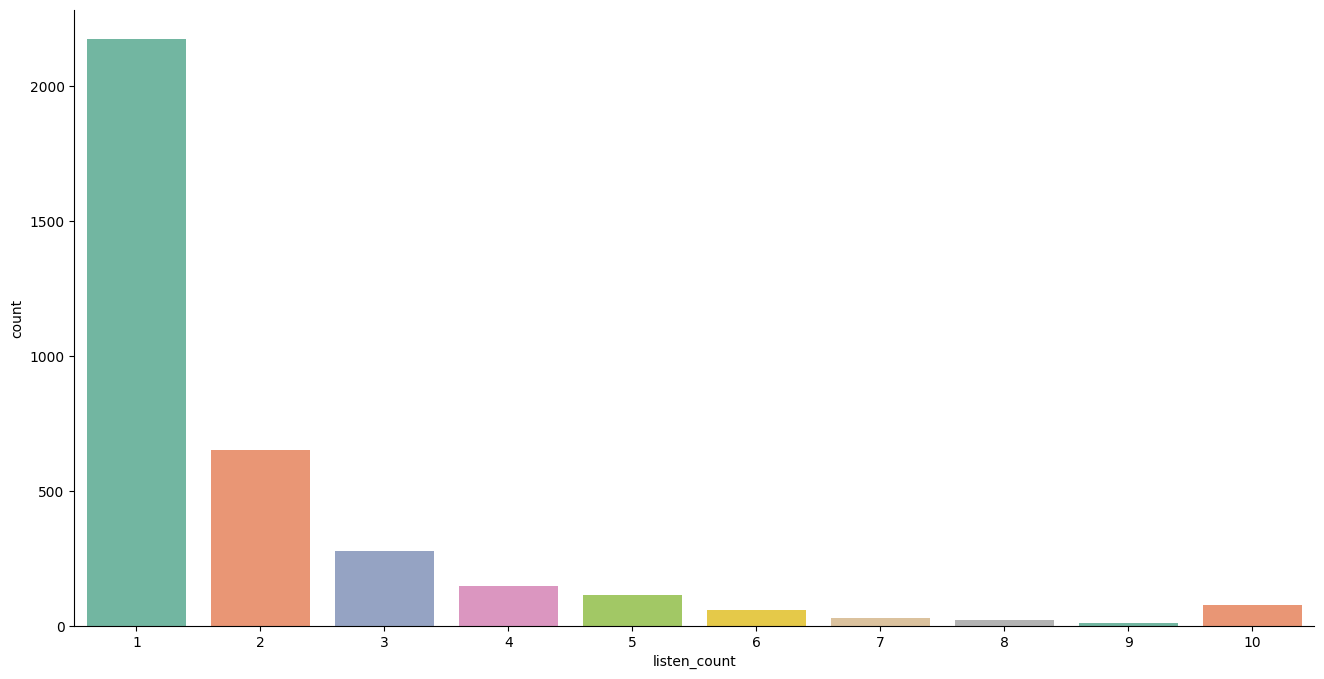

In [19]:
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set2', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [20]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id', 'listen_count']], reader)

In [26]:

trainset, testset = train_test_split(data, test_size=.25)

In [27]:
param_grid = {'n_factors': [160], 
              'n_epochs': [100], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.1]}

In [28]:
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

In [29]:
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done   7 out of  12 | elapsed:    0.2s remaining:    0.1s


1.7455490370172637
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.001, 'reg_all': 0.1}


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:    0.2s finished


In [30]:
# Perform the cross validation
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8654  1.6667  1.5731  1.9448  1.7000  1.7500  0.1356  
Fit time          0.11    0.09    0.09    0.09    0.09    0.09    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.86535861, 1.66672335, 1.57306722, 1.94482578, 1.70002506]),
 'fit_time': (0.11479973793029785,
  0.08959794044494629,
  0.09008073806762695,
  0.09012722969055176,
  0.08980679512023926),
 'test_time': (0.002821207046508789,
  0.0026290416717529297,
  0.002607107162475586,
  0.002836942672729492,
  0.0026161670684814453)}

In [31]:

final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")

RMSE: 1.7763
The RMSE is 1.776329105095284
